In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa
import os
from IPython.display import Audio
import scipy
from scipy.signal import find_peaks
from scipy.signal import butter, sosfilt, sosfreqz
from scipy.integrate import simps
from scipy.io.wavfile import write
import bisect
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score, accuracy_score
from scipy.fftpack import dct
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import make_scorer, f1_score
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler
scale = StandardScaler()
import sounddevice as sd
import wavio as wv
from datetime import datetime
import threading
import time
from time import sleep
from statistics import stdev
from sklearn.datasets import make_classification
from sklearn.feature_selection import mutual_info_classif

# Data Loading

In [2]:
# Real Cough Timestamps of the Data

def get_real_timestamps(audio_timestamp):

    timestamp = []
    f = open(audio_timestamp, "r")
    content = f.read()
    content = content.split("\n")

    for line in content:
        if line != "":
            timestamp.append((float(line.split("\t")[0]), float(line.split("\t")[1])))
    
    return timestamp

In [3]:
# Loading all data
def load_data(audio_file_path, timestamp_file_path, label, sr=48000):
    
    audio_files = [file for file in os.listdir(audio_file_path) if file.endswith('.wav')]
    timestamp_files = [file for file in os.listdir(timestamp_file_path) if file.endswith('.txt')]
    
    
    audios = []
    timestamps = []
    labels = []
    
    for file in audio_files:
    
        file_name = file.split(".wav")[0]    
        timestamp_files = [file.split("-label.txt")[0] for file in timestamp_files]    

        
        # Finding correspoding timestamp file
        index = timestamp_files.index(file_name)
        timestamp_data = timestamp_files[index]

        file_path = audio_file_path + file
        timestamp_path = timestamp_file_path + timestamp_data + '-label.txt'

        # Adding timestamps to the list
        real_timestamps = get_real_timestamps(timestamp_path)    

        # Loading audio_file
        data, sample_rate = librosa.load(file_path, sr=sr, mono=True)
        data = librosa.resample(data, orig_sr=sample_rate, target_sr=48000)
        
        audios.append(data)
        timestamps.append(real_timestamps)
        labels.append(label)

    
    return audios, timestamps, labels

In [4]:
audio_data = {'audio': [], 'timestamps': [], 'label': []}
sample_rate = 48000

cough_data, cough_timestamps, cough_labels = load_data('./audio-records/cough/', './audio-records/cough-timestamps/', 'cough')
other_data, other_timestamps, other_labels = load_data('./audio-records/no-cough/', './audio-records/no-cough-timestamps/', 'other')
dataset_cough_data, dataset_cough_timestamps, dataset_cough_labels = load_data('./audio-records/dataset-cough-recordings/', './audio-records/dataset-cough-timestamps/', 'cough')
dataset_other_data, dataset_other_timestamps, dataset_other_labels = load_data('./audio-records/dataset-other-recordings/', './audio-records/dataset-other-timestamps/', 'other')

# Own data
audio_data['audio'].extend(cough_data)
audio_data['timestamps'].extend(cough_timestamps)
audio_data['label'].extend(cough_labels)

audio_data['audio'].extend(other_data)
audio_data['timestamps'].extend(other_timestamps)
audio_data['label'].extend(other_labels)

# Data from the internet
audio_data['audio'].extend(dataset_cough_data)
audio_data['timestamps'].extend(dataset_cough_timestamps)
audio_data['label'].extend(dataset_cough_labels)

audio_data['audio'].extend(dataset_other_data)
audio_data['timestamps'].extend(dataset_other_timestamps)
audio_data['label'].extend(dataset_other_labels)

# Preprocessing

In [5]:
# Data Normalization

def normalize_data(data):
    min = np.min(data)
    max = np.max(data)

    data = (data - min) / (max - min)
    return data

In [12]:
# Moving Average of the Data:
def compute_moving_average(data, window_size=10):
    
    kernel = np.ones(window_size) / window_size
    moving_averages = np.convolve(data, kernel, mode='valid')
    moving_averages = np.round(moving_averages, 2)
    
    return np.array(moving_averages)

In [13]:
# Filtering of the data

def butter_bandpass(lowcut, highcut, fs, order=8):
        nyq = 0.5 * fs
        low = lowcut / nyq
        high = highcut / nyq
        sos = butter(order, [low, high], analog=False, btype='band', output='sos')
        return sos

def butter_bandpass_filter(data, lowcut, highcut, fs, order=8):
        sos = butter_bandpass(lowcut, highcut, fs, order=order)
        y = sosfilt(sos, data)
        return y

In [14]:
# Preprocessing 
def preprocess_data(data):
    
    # Filtering data
    data = butter_bandpass_filter(data, 1000, 4000, sample_rate,8)

    # Getting moving average of the data
    data = compute_moving_average(np.abs(data))
    
    # Normalize data
    data = normalize_data(data)
    data = data.flatten()
    
    return data   

In [70]:
df_audio = pd.DataFrame.from_dict(audio_data)
df_audio = df_audio[df_audio['label'] == 'cough']

for row in df_audio.values:
    
    audio = row[0]
    row[0] = preprocess_data(audio)
    
df_audio

,audio,timestamps,label
0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[(3.33773, 3.927718), (9.447733, 9.969193), (1...",cough
1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[(7.6774, 8.272404), (25.127484, 25.722488), (...",cough
2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[(1.606082, 2.141442), (3.545501, 4.171772), (...",cough
3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[(1.018684, 1.898457), (10.27945, 11.112919), ...",cough
4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[(3.190435, 4.17902), (10.829504, 11.728218), ...",cough
...,...,...,...
94,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[(1.359033, 1.763472), (1.79321, 2.242256), (2...",cough
95,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[(0.015235, 0.554972), (0.66379, 1.175235), (1...",cough
96,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[(0.044676, 0.543559), (1.280715, 1.921072), (...",cough
97,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[(4.497394, 4.817573)]",cough


In [71]:
# Analyze

timestamp_stat = [] # each element: (start, max, finish)

df_cough_audio = df_audio[df_audio['label'] == 'cough']


for audio_info in df_cough_audio.values:
    
    audio = audio_info[0]
    timestamps = audio_info[1]
    
    for timestamp in timestamps:
        
        start = timestamp[0]
        finish = timestamp[1]
        
        start_idx = int(start * sample_rate)
        finish_idx = int(finish * sample_rate)
        
        extracted = audio[start_idx:finish_idx]
        
        max_index = np.argmax(extracted)
        max_timestamp = start + max_index / sample_rate
        
        timestamp_stat.append((start, max_timestamp, finish))


percentages = []
cough_time = []

# The important thing is to find the percentage of start to peak and peak to end
for element in timestamp_stat:
    
    start = element[0]
    max = element[1]
    finish = element[2]
    
    time = finish - start
    
    cough_time.append(time)
    
    part_1 = max - start
    part_2 = finish - max
    
    percentages.append((part_1 / time, part_2 / time))

print(np.array(percentages))

percent_array = np.array(percentages)

print()
print(percent_array.T)

first_percentile = np.mean(percent_array.T[0])
second_percentile = np.mean(percent_array.T[1])

print()
print(first_percentile)
print(second_percentile)

print()
cough_time.sort()
print(cough_time[0:20])
print()
print(cough_time[-20:])

[[0.44619552 0.55380448]
 [0.5807013  0.4192987 ]
 [0.52922815 0.47077185]
 ...
 [0.29975002 0.70024998]
 [0.26421933 0.73578067]
 [0.3046984  0.6953016 ]]

[[0.44619552 0.5807013  0.52922815 ... 0.29975002 0.26421933 0.3046984 ]
 [0.55380448 0.4192987  0.47077185 ... 0.70024998 0.73578067 0.6953016 ]]

0.2128609312298377
0.7871390687701623

[0.04678100000000285, 0.05235100000000159, 0.06794400000000422, 0.07568099999999944, 0.08707500000000001, 0.10247400000000084, 0.1347990000000001, 0.14271300000000053, 0.14878500000000017, 0.15499399999999985, 0.156366, 0.15702300000000058, 0.16873100000000107, 0.1734839999999993, 0.18513499999999983, 0.18901900000000005, 0.19700900000000043, 0.1981919999999988, 0.2039010000000001, 0.21018499999999563]

[0.863737, 0.8706950000000049, 0.8797730000000001, 0.898714, 0.975428, 0.975428, 0.9885850000000005, 1.0064380000000028, 1.0827470000000003, 1.1186200000000008, 1.1475130000000036, 1.214694999999999, 1.361228000000004, 1.400595000000001, 1.636560000

# Cough Detection

In [72]:
# Summation of the frequency bins in a spectogram

def get_frequency_sums(mel_spectrogram_db):
    
    sums = []

    for bin in mel_spectrogram_db:
        sums.append(np.sum(bin))

    sums = np.array(sums)

    return sums

In [73]:
def detect_coughs_freq_domain(data, percentile_threshold):
    
    duration = len(data) / sample_rate
    
    mel_spectrogram = librosa.feature.melspectrogram(y=data, sr=sample_rate).T
    mel_spectrogram_db = librosa.amplitude_to_db(mel_spectrogram, ref=np.max)    
    
    frequency_sums = get_frequency_sums(mel_spectrogram_db)
    
    # Threshold 
    threshold = np.percentile(frequency_sums, percentile_threshold)
    
    # Peak detection
    cough_indices, _ = find_peaks(frequency_sums, prominence = 0.4)
    cough_indices = list(cough_indices)
    
    # Deleting overlaps in the peaks - Avoiding to count same cough more than one
    i = 0
    
    while i < len(cough_indices):

        peak = cough_indices[i]
        peak_range = (peak - 25, peak + 25) # The range is determined experimentally

        overlap_indices = [index for index in cough_indices
                       if peak_range[0] < index < peak_range[1]]

        if len(overlap_indices) > 1:

            # Find the index with maximum amplitude 
            max = overlap_indices[0]
            for index in overlap_indices:
                if (frequency_sums[index] > frequency_sums[max]):
                    max = index

            overlap_indices.remove(max)

            for element in overlap_indices:
                cough_indices.remove(element)

        i += 1

    # Applying the threshold
    cough_indices = [index for index in cough_indices if index > threshold]
    
    # Finding the timestamps of the coughs
    predicted_timestamps = []
    
    total_samples = len(data)
    data_length = len(frequency_sums)
    
    # Finding the timestamps of the coughs
    for index in cough_indices:
        
        actual_index = total_samples * index / data_length
        actual_timestamp = round(actual_index / sample_rate, 6)
        
        predicted_timestamps.append(actual_timestamp)
    
    # Filtering the sound after coughing
    for ts in predicted_timestamps:
        match = list((ts_2 for ts_2 in predicted_timestamps if ts < ts_2 < ts + 0.1))
        if len(match) != 0:
            index = predicted_timestamps.index(match[0])
            predicted_timestamps.remove(match[0])
            cough_indices.remove(cough_indices[index])

    
    return cough_indices, predicted_timestamps

In [74]:
# Cough Detection Algorithm

def detect_coughs_time_domainnn(data, percentile_threshold):

    # Threshold 
    threshold = np.percentile(data, percentile_threshold)

    # Peak detection
    cough_indices, _ = find_peaks(data, prominence = 0.4)
    cough_indices = list(cough_indices)

    # Deleting overlaps in the peaks - Avoiding to count same cough more than one
    i = 0
    while i < len(cough_indices):

        peak = cough_indices[i]
        peak_range = (peak - 2500, peak + 2500) # The range is determined experimentally

        overlap_indices = [index for index in cough_indices
                       if peak_range[0] < index < peak_range[1]]
        
        if len(overlap_indices) > 1:

            # Find the index with maximum amplitude 
            max = overlap_indices[0]
            for index in overlap_indices:
                if (data[index] > data[max]):
                    max = index

            overlap_indices.remove(max)

            for element in overlap_indices:
                cough_indices.remove(element)

        i += 1
        
    # Applying the threshold
    cough_indices = [index for index in cough_indices if index > threshold]

    # Finding the timestamps of the coughs
    predicted_timestamps = []
    for index in cough_indices:
        predicted_timestamps.append(round(index / sample_rate, 6))


    # Filtering the sound after coughing
    for ts in predicted_timestamps:
        matches = list((ts_2 for ts_2 in predicted_timestamps if ts < ts_2 < ts + 0.1))

        if len(matches) != 0:
            for i in range(len(matches)):
                index = predicted_timestamps.index(matches[i])
                predicted_timestamps.remove(matches[i])
                cough_indices.remove(cough_indices[index])

    return cough_indices, predicted_timestamps

In [81]:
def detect_coughs_time_domain(data, percentile_threshold):
    
    # Percentile threshold
    threshold = np.percentile(data, percentile_threshold)
    
    # Peak detection
    cough_indices, _ = find_peaks(data, height=threshold)
    cough_indices = list(cough_indices)
    
    # Deleting overlaps in the peaks - Avoiding to count same cough more than one
    i = 0
    
    while i < len(cough_indices):

        peak = cough_indices[i]
        peak_range = (peak - 3600, peak + 3600) # Getting 0.15 seconds before and after

        overlap_indices = [index for index in cough_indices
                       if peak_range[0] < index < peak_range[1]]
        
        if len(overlap_indices) > 1:

            # Find the index with maximum amplitude 
            max = overlap_indices[0]
            for index in overlap_indices:
                if (data[index] > data[max]):
                    max = index

            overlap_indices.remove(max)

            for element in overlap_indices:
                cough_indices.remove(element)

        i += 1
        
    predicted_timestamps = np.round(np.array(cough_indices) / sample_rate, 6).tolist()


    return cough_indices, predicted_timestamps

In [82]:
def extract_coughs(preprocessed_data, percentile_threshold=10):
    
    # Extraction of high frequency signals (cough/other) from the audio
    audio_peak_extractions = []
    
    # Time-based and frequency-based extractions
    cough_indices_time, predicted_timestamps_time = detect_coughs_time_domain(preprocessed_data, percentile_threshold)
    #cough_indices_freq, predicted_timestamps_freq = detect_coughs_freq_domain(preprocessed_data, percentile_threshold)

    predicted_timestamps = predicted_timestamps_time
    
    # Getting the extracted data
    for timestamp in predicted_timestamps:
        
        timestamp_index = int(timestamp * sample_rate)
        #peak_magnitude = preprocessed_data[timestamp_index] * 0.01
        peak_magnitude = 0.01        
            
        # For start_index
        start_index = 0
        finish_index = timestamp_index
            
        i = int(timestamp_index - 0.05 * sample_rate)
        
        while i > 0:
            if (data[i] < peak_magnitude):
                start_index = i
                break
            
            
            i -= 1
        
        # For finish index of extracted data
        j = int(timestamp_index + 0.05 * sample_rate)
        
        while j < len(data):
            if (data[j] < peak_magnitude):
                finish_index = j
                break
            
            j += 1
            
        predicted_start_time = start_index / sample_rate
        predicted_end_time = finish_index / sample_rate 

        audio_peak_extractions.append((predicted_start_time, predicted_end_time))
        
    return audio_peak_extractions

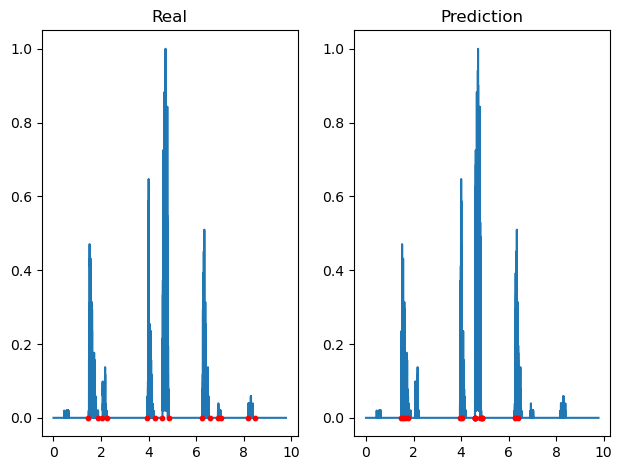


4
3



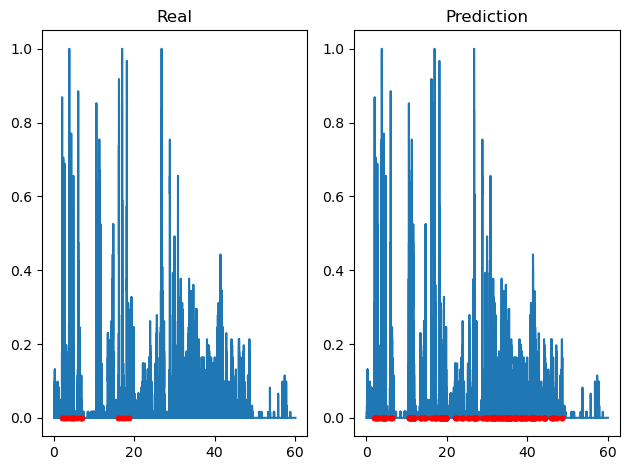


9
1



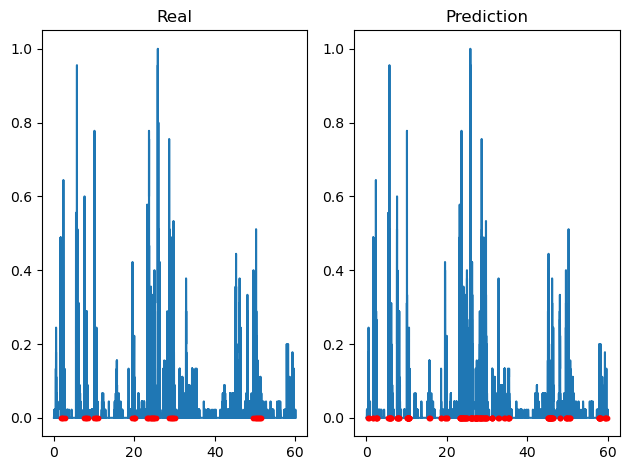


19
1



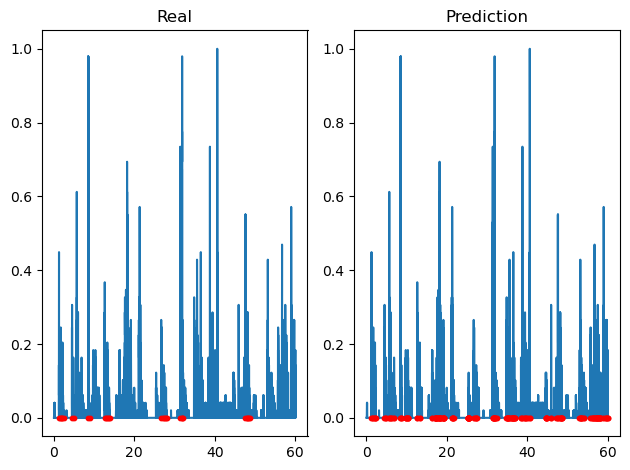


14
2



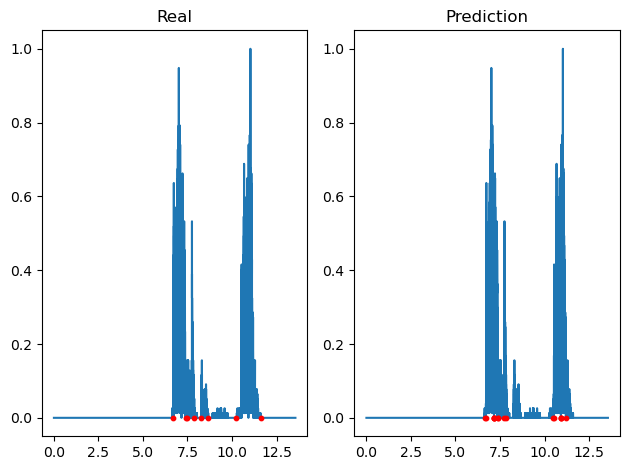


3
1



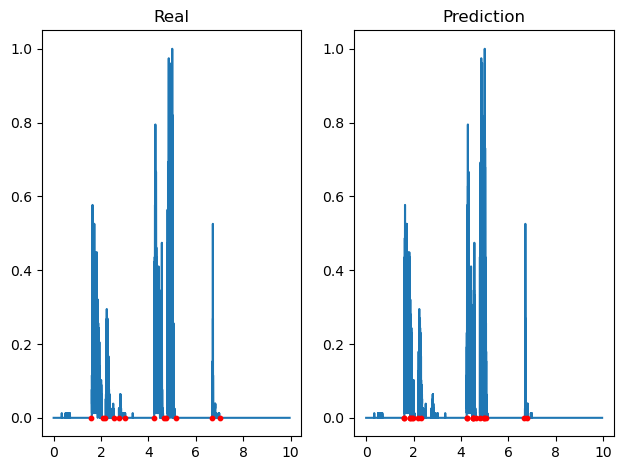


5
1



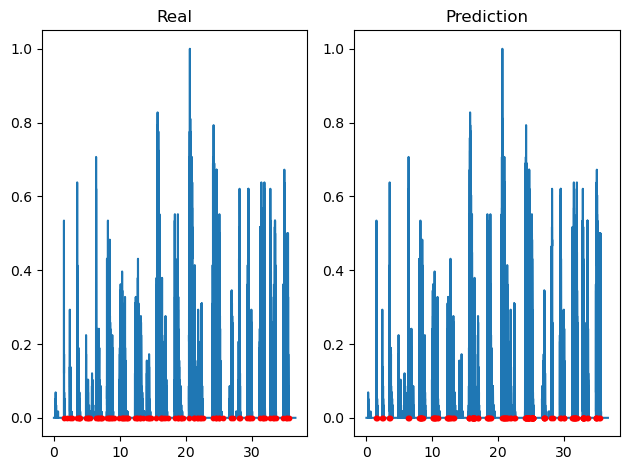


34
10



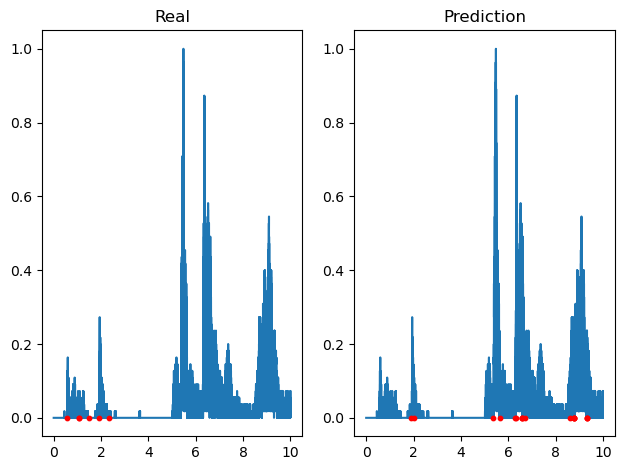


1
2



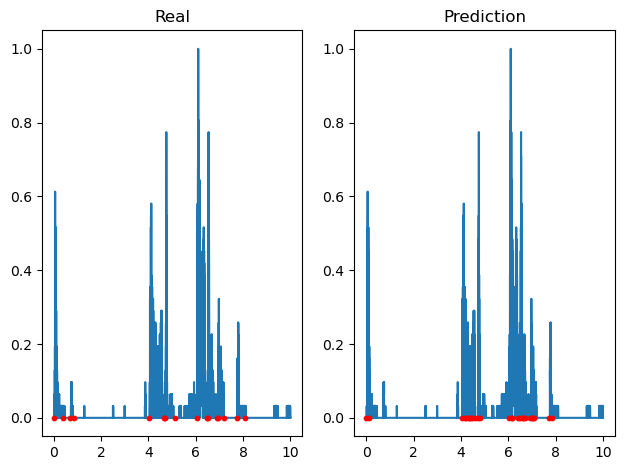


7
1



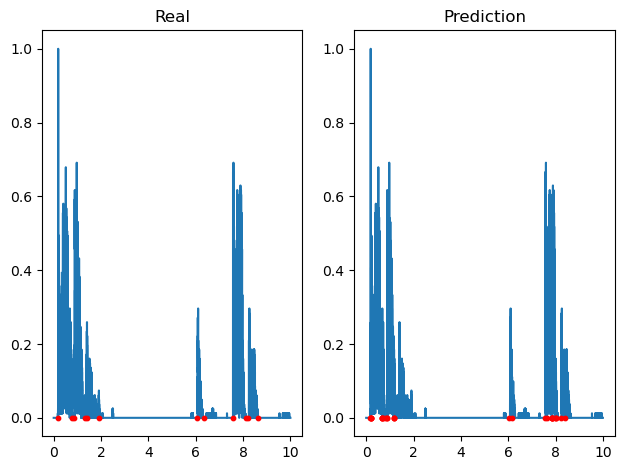


5
1



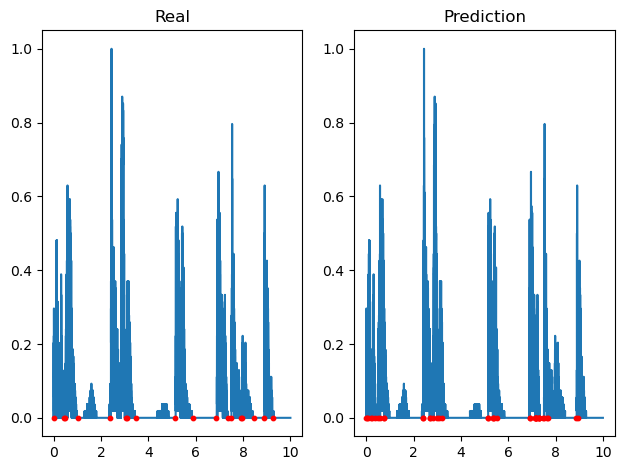


8
1



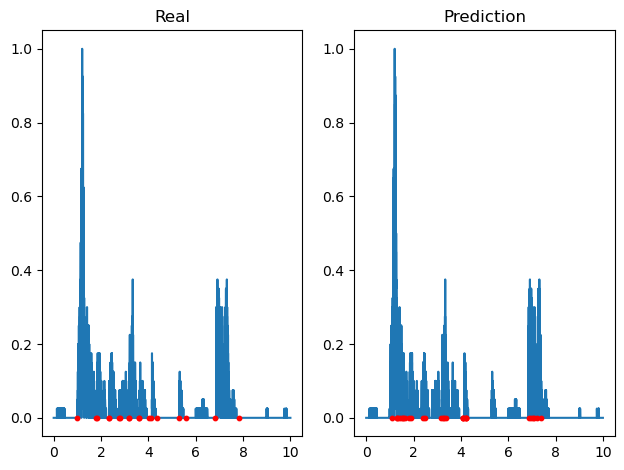


8
1



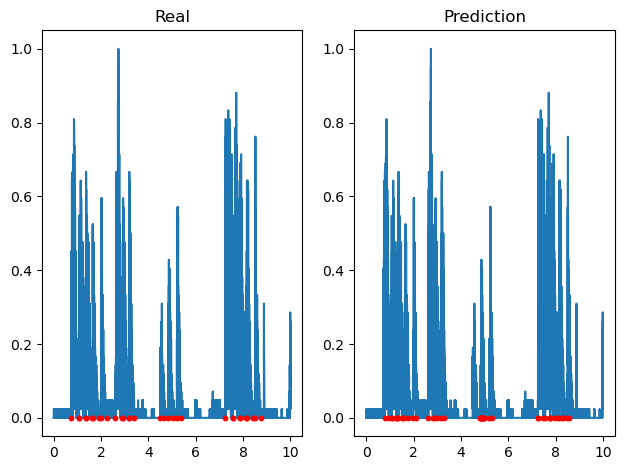


15
1



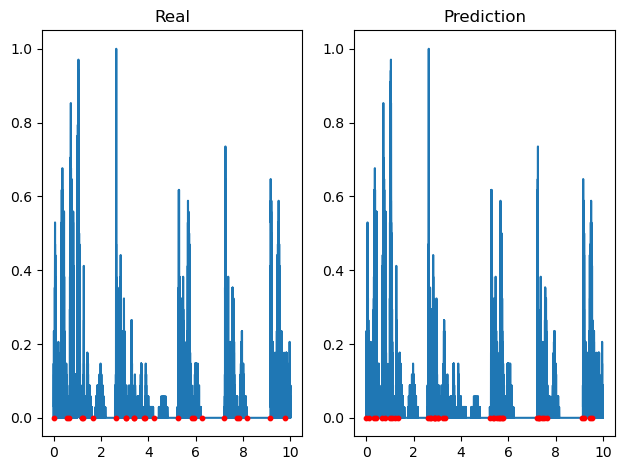


9
3


488
29


In [83]:
cough_detected = 0
cough_missed = 0

for audio_info in df_audio.values:
        
    session_detected = 0
    session_missed = 0
    
    data = audio_info[0]
    time = np.arange(0, len(data)) / sample_rate
    
    cough_timestamps = audio_info[1]
    detected_timestamps = extract_coughs(data, percentile_threshold=98)

    for start, finish in cough_timestamps:
        
        for detected_start, detected_finish in detected_timestamps:
            
            if (start - 0.1 < detected_start < finish + 0.1 or start - 0.1 < detected_finish < finish + 0.1):
                 
                cough_detected += 1
                session_detected += 1
                break  
                
        else:

            cough_missed += 1
            session_missed += 1
            

    
    if (session_missed !=  0): 
        plt.subplot(1, 2, 1)
        plt.title("Real")
        plt.plot(time, data, label='Signal')
        plt.scatter(cough_timestamps, np.zeros_like(cough_timestamps), marker='o', color='red', label='Real Timestamps', s=10, zorder=5)

        # Plot predicted timestamps
        plt.subplot(1, 2, 2)
        plt.title("Prediction")
        plt.plot(time, data, label='Signal')
        plt.scatter(detected_timestamps, np.zeros_like(detected_timestamps), marker='o', color='red', label='Predicted Timestamps', s=10, zorder=5)

        plt.tight_layout()
        plt.show()
        print()

    
        print(session_detected)
        print(session_missed)
        print()
    
    
print()
print(cough_detected)
print(cough_missed)

In [73]:
performance = (cough_detected / (cough_detected + cough_missed)) * 100
print(performance)

81.14434330299089
